Here we want to check two specific relationships which we will use for the deduplication of UMIs.

First, we assume that the relationship between counts for UMIs A and B, where A = true and B = error is predictable. To test this, we will look for examples where there all the UMIs for a gene fall are adjacent to one another (i.e the most abundant is true and all adj. are errors; we will discard cases with > 10 UMIs).

Second, we assume that the # read per UMI is independent on gene expression level. We need to work out how to test this. We may have to resort to our heuristic dedup (possibly run group and count on the same bam and correlate group counts with gene expression?)

First, let's parse a grouped 10X BAM summary flatfile and identify these genes with all adj UMIs.

In [1]:
import pysam
import collections
import pandas as pd
import umi_tools._dedup_umi as dedup_umi
%load_ext rpy2.ipython
%matplotlib inline  

In [2]:
%%R
library(ggplot2)
my_theme <- theme_bw() + theme(text=element_text(size=20), aspect.ratio=1)

In [3]:
infile = "../run/mapped/"

The groups are ordered by gene then cell. Thus, if we observed more than one groups before the cell changes, we can skip the cell entirely

In [6]:
print(dedup_umi.edit_distance(bytes("ATATG", encoding="utf-8"), bytes("ATATT", encoding="utf-8")))

1


In [7]:
reads_per_group = collections.Counter()

with open(infile, "r") as inf:
    header=next(inf)
    first_line = next(inf)
    read_id, contig, pos, gene, umi, n_umi, final_umi, n_final_umi, unique_id = first_line.strip().split("\t")
    previous_group = unique_id
    for line in inf:
        read_id, contig, pos, gene, umi, n_umi, final_umi, n_final_umi, unique_id = line.strip().split("\t")
        if unique_id != previous_group:
            reads_per_group[n_final_umi] += 1
            previous_group = unique_id
print(len(reads_per_group))

FileNotFoundError: [Errno 2] No such file or directory: '../run/mapped/testing_group_t_3k.bam'

In [172]:
reads_per_group_df = pd.DataFrame.from_records(reads_per_group.most_common(), columns=["num", "freq"])
reads_per_group_df['fraction'] = [x/sum(reads_per_group_df['freq']) for x in reads_per_group_df['freq']]
print(reads_per_group_df.head())

  num     freq  fraction
0   1  2151506  0.695927
1   2   692412  0.223968
2   3   188041  0.060824
3   4    45454  0.014703
4   5    10587  0.003424


  num    freq     fraction
0   1 2151506 0.6959268902
1   2  692412 0.2239678299
2   3  188041 0.0608238082
3   4   45454 0.0147025669
4   5   10587 0.0034244748
5   6    2490 0.0008054163


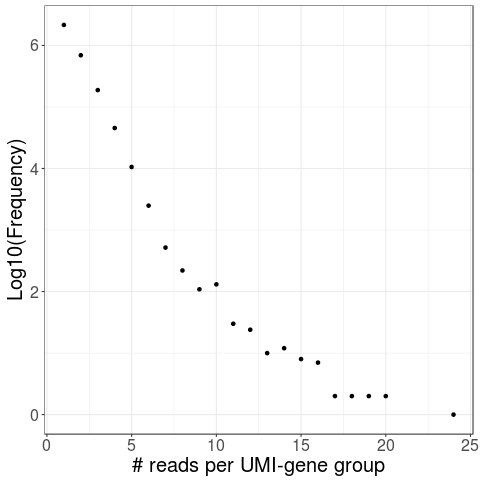

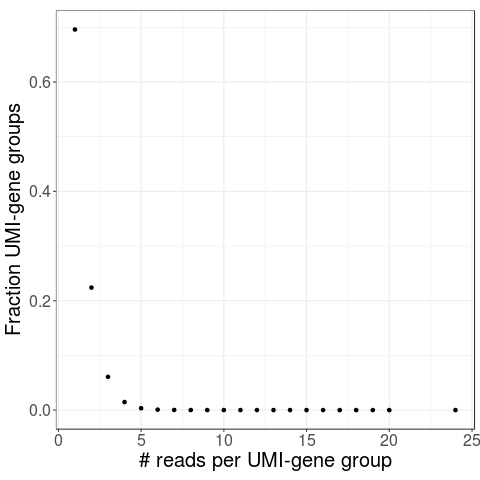

In [125]:
%%R -i reads_per_group_df
print(head(reads_per_group_df))
p <- ggplot(reads_per_group_df, aes(as.numeric(as.character(num)), log(freq,10))) +
geom_point() + my_theme + xlab("# reads per UMI-gene group") + ylab("Log10(Frequency)")
print(p)

p <- ggplot(reads_per_group_df, aes(as.numeric(as.character(num)),fraction)) +
geom_point() + my_theme + xlab("# reads per UMI-gene group") + ylab("Fraction UMI-gene groups")
print(p)

In [94]:
rows = []
with open(infile, "r") as inf:
    header=next(inf)
    first_line = next(inf)
    #print(header)
    #print(first_line)
    read_id, contig, pos, gene, umi, n_umi, final_umi, n_final_umi, unique_id = first_line.strip().split("\t")
    cell = read_id.split("_")[-2]
    #print(cell, unique_id)
    previous_gene = gene
    previous_cell = cell
    cell_group = unique_id
    umi_counts = collections.Counter()
    umi_counts[umi] += 1
    skip_cell = None
    n = 0
    n2 = 0
    for line in inf:
        n+=1
        #print(line)
        read_id, contig, pos, gene, umi, n_umi, final_umi, n_final_umi, unique_id = line.strip().split("\t")
        cell = read_id.split("_")[-2]
        #print(cell, unique_id)
        
        if cell == skip_cell:
            #print("skipping..")
            #break
            continue
        
        if gene != previous_gene or cell != previous_cell:
            if len(umi_counts) > 1:
                if not skip_cell:
                    n2 += 1
                    #print(line)
                    #print("skip_cell", skip_cell)
                    #print(gene, previous_gene, cell, previous_cell, umi_counts)
                    top_umi, top_count = umi_counts.most_common()[0]
                    for error_umi, error_count in umi_counts.most_common()[1:]:
                        if dedup_umi.edit_distance(
                            bytes(top_umi, encoding="utf-8"), bytes(error_umi, encoding="utf-8")) == 1:
                            rows.append([top_count, error_count])
                    #if n2 > 1000:
                    #    break
                else:
                    pass
                    #print("this was a skipped cell")
                    #print(skip_cell)
                    #print(gene, previous_gene, cell, previous_cell, umi_counts)
            
            previous_gene = gene
            previous_cell = cell
            cell_group = unique_id
            umi_counts = collections.Counter()
            umi_counts[umi] += 1
            skip_cell = None
        
        else:
            if unique_id != cell_group:
                #print(unique_id, cell_group)
                skip_cell = cell
                #print("set up skipping for cell:", skip_cell)
                
            umi_counts[umi] += 1
print(n)


4359148


In [95]:
final_df = pd.DataFrame.from_records(rows, columns=["true_count", "error_count"])
print(final_df.head())

   true_count  error_count
0           1            1
1           1            1
2           2            1
3           2            1
4           1            1


In [176]:
tab_true = pd.DataFrame(final_df['true_count'].value_counts())
tab_true.columns = ["num_times_error"]
reads_per_group_df['num'] = reads_per_group_df['num'].astype(int)
reads_per_group_df = reads_per_group_df.merge(tab_true, left_on="num", right_index=True, how="inner")


In [128]:
%%R -i final_df
print(dim(final_df))

[1] 1099    2


  num    freq    fraction num_times_error
0   1 2151506 0.695926890             706
1   2  692412 0.223967830             286
2   3  188041 0.060823808              85
3   4   45454 0.014702567              18
4   5   10587 0.003424475               4


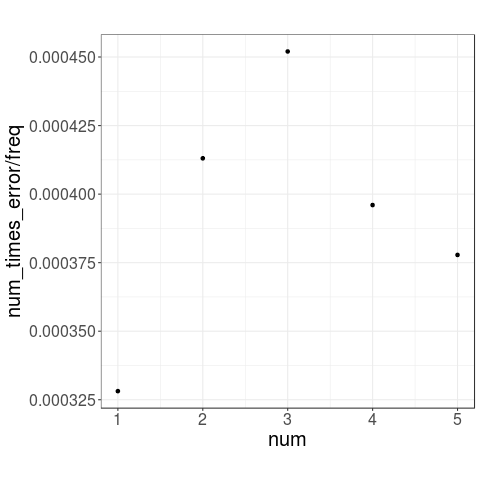

In [179]:
%%R -i reads_per_group_df

print(head(reads_per_group_df))
p <- ggplot(reads_per_group_df, aes(num, num_times_error/freq)) + geom_point() + my_theme +

print(p)

  true_count error_count
0          1           1
1          1           1
2          2           1
3          2           1
4          1           1
5          1           1
  num    freq     fraction
0   1 2151506 0.6959268902
1   2  692412 0.2239678299
2   3  188041 0.0608238082
3   4   45454 0.0147025669
4   5   10587 0.0034244748
5   6    2490 0.0008054163

  1   2   3   4   5 
706 286  85  18   4 


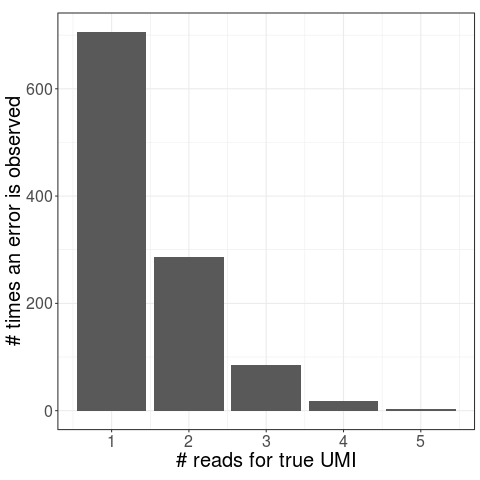

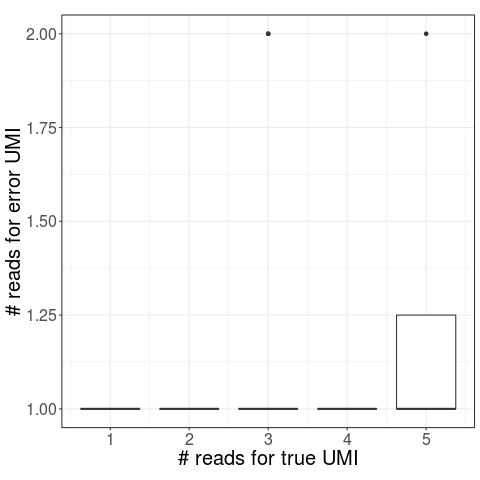

In [132]:
%%R -i final_df 
library(ggplot2)
print(head(final_df))




p <- ggplot(final_df, aes(true_count, 1)) + stat_summary(geom="bar", fun.y=sum) +
my_theme + xlab("# reads for true UMI") + ylab("# times an error is observed")
print(p)

p <- ggplot(final_df, aes(true_count, error_count, group=true_count)) + geom_boxplot() +
my_theme + xlab("# reads for true UMI") + ylab("# reads for error UMI")
print(p)